In [1]:
# import packages
from math import sqrt,ceil,floor
import math
# import trackpy as tp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
# from numba import jit,prange
# import numba
from scipy.stats import gaussian_kde,norm
from scipy.interpolate import splev, splrep
from scipy.optimize import curve_fit
import time
import datetime
import os
import glob
from tqdm import tqdm
import itertools

from pathlib import Path

# for list slicing.
from operator import itemgetter

import cv2 #package for image analysis
from scipy import spatial # for KD tree

plt.rcParams['font.size']=20
plt.rcParams["font.family"] = "Times New Roman"

# plt.rcParams["mathtext.fontset"] = font2
from IPython.display import Latex
from IPython.display import Markdown

In [2]:
# subFolder='Simul_20190212_dblLineAsym2'
# subFolder='Simul_20190212_dblLineAsym2_drag2'
# subFolder='Simul_n4_20190114_S25_dilute_WrongPassiveVoltage' # ran with the 20190214_dblLineAsym\DEP20X1p5X_S25_2TMA_0H2O2_0p64pp_flippedDevice_007_EnergyForceProfiles.csv
# subFolder='CheckPressureTheoryNewFunctionExpt' # ran with the 20190214_dblLineAsym\DEP20X1p5X_S25_2TMA_0H2O2_0p64pp_flippedDevice_007_EnergyForceProfiles.csv

# subFolder='ExtremeAsymBiharmonic' 
# subFolder='ThermalLimitBiHarmonic'
# subFolder='ThermalLimitBiHarmonicSym2'

# subFolder='ExtremeAsymHarmonicAgain2'

subFolder='20190926_HMDS_AF_tau_SDS_Relay/Drag2' # agrees with theory P, as long as low persistence length compared to bulk
subFolder='20190926_HMDS_AF_tau_SDS_Relay/FitDrag' # agrees with theory P, as long as low persistence length compared to bulk
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\FitDrag_movie'
subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan' 
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\ShortRun5fps' # used for the experimetal results in the paper.  - PAPER 

# subFolder='20190212_dblLineAsym2/With008CalibDragMult2' # agrees with theory P, as long as low persistence length compared to bulk
subFolder =r'20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls'

CurrentFolder=os.getcwd()
CurrentFolder=CurrentFolder.replace('\\',r'/')+'/'+subFolder

In [3]:
print(CurrentFolder)
filelistMeta=glob.glob(CurrentFolder+'/*MetaData.csv')
filelistPDF=glob.glob(CurrentFolder+'/*PDfunc.csv')
DataSummary=pd.DataFrame()
for filename in filelistMeta:
    DataSummary=DataSummary.append(pd.read_csv(filename,index_col=False))
DataSummary['tau_s'] = 1/DataSummary['D_R_Ps']
DataSummary['Force_Norm'] = DataSummary['AverageForceLeft_N']/DataSummary['tau_s']/DataSummary['ProbAtCenter']
DataSummary['Persistence_length_um'] = DataSummary['velocity_umPs'] * DataSummary['tau_s']
print('Voltages:', np.sort(pd.unique(DataSummary['ActiveVoltage'])))
print('Velocities:',np.sort(pd.unique(DataSummary['velocity_umPs'])))
print('D_R:',np.sort(pd.unique(DataSummary['D_R_Ps'])))
print('Number Of particles:',np.sort(pd.unique(DataSummary['NumberOfParticles'])))
print('Drag multipliers', np.sort(pd.unique(DataSummary['drag_multiplier'])))
print('Torque ratio C', np.sort(pd.unique(DataSummary['C_ratio_dlctrc_cnst'])))
print('l_p', np.sort(pd.unique(DataSummary['Persistence_length_um'])))

C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls
Voltages: [8]
Velocities: [1]
D_R: [0.02 0.1 ]
Number Of particles: [10]
Drag multipliers [1.82]
Torque ratio C [1]
l_p [10. 50.]


In [216]:
def latexify(fig_width=None, fig_height=None, columns=1, fontsize = 8):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': fontsize, # fontsize for x and y labels (was 10)
              'axes.titlesize': fontsize,
              # 'text.fontsize': fontsize, # was 10
              'font.size': fontsize,
              'legend.fontsize': fontsize -2, # was 10
              'xtick.labelsize': fontsize,
              'ytick.labelsize': fontsize,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif',
              'legend.handlelength': 1.0, 
              'lines.markersize'  : 3,
              'legend.labelspacing' : 0.2,
              'legend.columnspacing': 0.5}

    plt.rcParams.update(params)
def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

## Plots: general

In [8]:
# Add feature to sum pressure only on last frames, using coords. 
PlotVariables=['ActiveVoltage', 'velocity_umPs',   'D_R_Ps',         'NumberOfParticles', 'C_ratio_dlctrc_cnst', 'drag_multiplier']
VariableStrings=['$V$ [V]',     '$v$ [$\mu$m/$s$]','D_{\mathrm{R}}', '\# particles',      'C ratio',              'drag_multiplier']
indsToConstantVariables=  [0, 1]; 
ValuesOfConstantVariables=[8, 1]

MaximalVelocity = 200
ChosenVelocities=[1]
PlotTheory=True
ForceProbCenter=True
UseChosenVelocitiesOnly = False
XlimForDensityPlot=(-10,110)
ind_to_X_axis=1
ind_to_legend=2 # legend of the density plot. 

Total points after velocity filter 2
2 ActiveVoltage 8
2 velocity_umPs 1


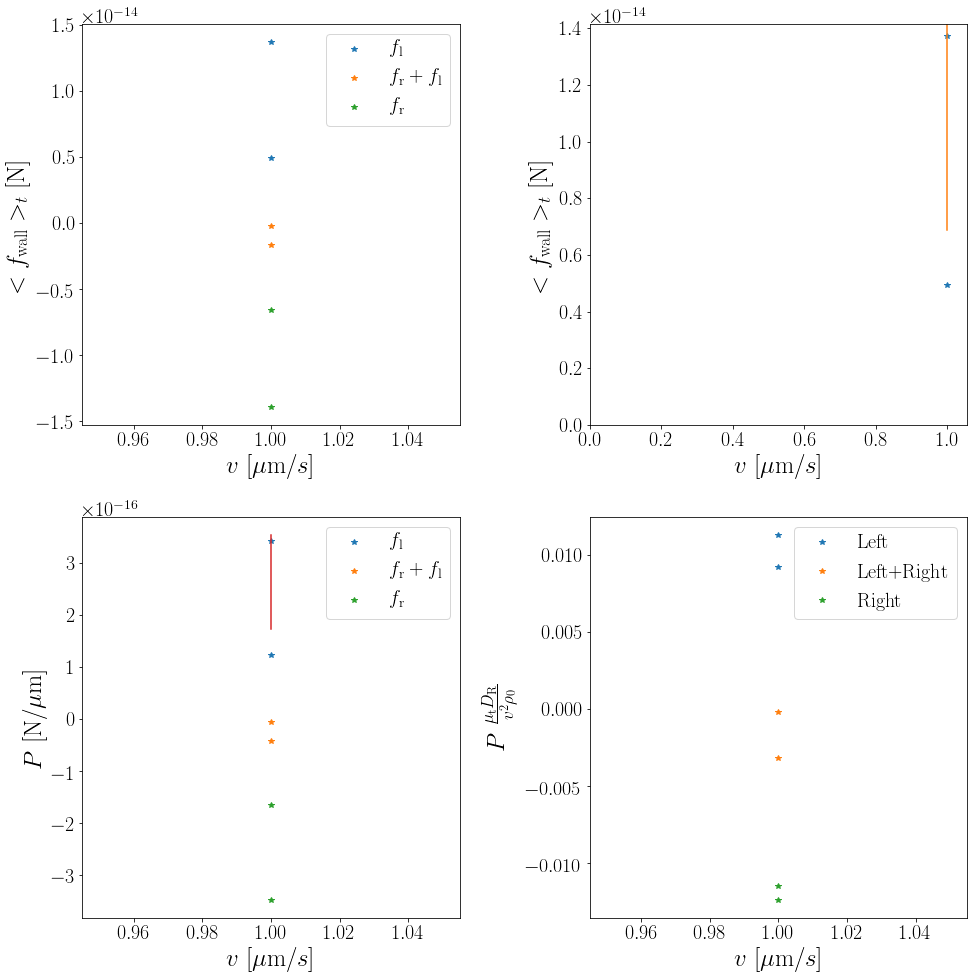

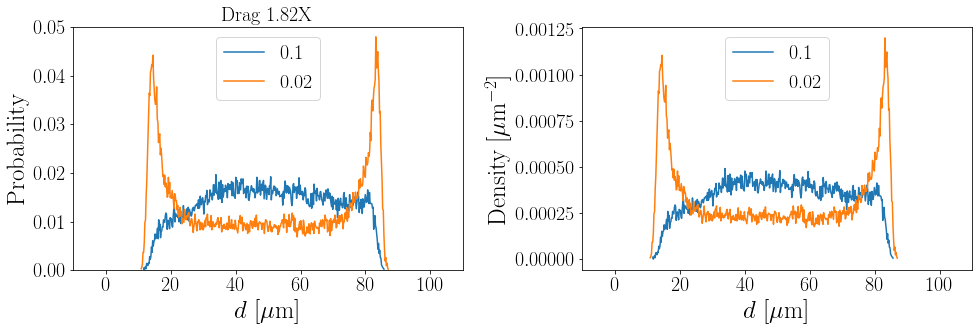

In [9]:
# all plots
if 1: # filter results
    ConstantVariableNames=itemgetter(*indsToConstantVariables)(PlotVariables)
    DFforPlot=DataSummary.copy()
    DFforPlot=DFforPlot.loc[DFforPlot['velocity_umPs']<MaximalVelocity]
    if UseChosenVelocitiesOnly:
        DFforPlot=DFforPlot.loc[DFforPlot['velocity_umPs'].isin(ChosenVelocities)] 
    print('Total points after velocity filter', len(DFforPlot))
    for ConstantVariableName,ValueOfConstantVariable in zip(ConstantVariableNames,ValuesOfConstantVariables):
        if ConstantVariableName in DFforPlot.columns:
            DFforPlot=DFforPlot.loc[np.abs((DFforPlot[ConstantVariableName]-ValueOfConstantVariable))<np.abs(ValueOfConstantVariable/1000)]
            print(len(DFforPlot), ConstantVariableName, ValueOfConstantVariable)
    # sorting by legend index
    DFforPlot=DFforPlot.sort_values(PlotVariables[ind_to_legend], ascending = False)
    # Use arrays for plots
    X_axis=DFforPlot[PlotVariables[ind_to_X_axis]]
    HalfAdd=str()
    if 'AverageForceLeft_N_lastHalf' in DFforPlot.columns:
        HalfAdd='_lastHalf'
    plotLeftForce  = DFforPlot['AverageForceLeft_N'+HalfAdd].values;
    plotRightForce = DFforPlot['AverageForceRight_N'+HalfAdd].values;
    plotSumForce   = DFforPlot['SumAverageForce_N'+HalfAdd].values;
    plotLeftP  = DFforPlot['PressureLeft_NPum'+HalfAdd].values;
    plotRightP = DFforPlot['PressureRight_NPum'+HalfAdd].values;
    plotSumP   = DFforPlot['SumPressure_NPum'+HalfAdd].values;
    mobilities=1/DFforPlot['drag_N_sPum'].values;
    ProbsAtCenter=DFforPlot['ProbAtCenter']
    ForcedDensityAtCneter=list()
    NumberOfParticlesArray=DFforPlot['NumberOfParticles']
    plt.rcParams['font.size']=20
    fig1, ax1=plt.subplots(2,2, figsize=([14,14])) 
if 1: # Plots: 0,0 and 0,1 forces    
    ax1[0,0].plot(X_axis,plotLeftForce, '*')
    ax1[0,0].plot(X_axis,plotSumForce, '*')
    ax1[0,0].plot(X_axis,plotRightForce, '*')
    ax1[0,0].set_ylabel('$<f_{\mathrm{wall}}>_t$ $\mathrm{[N]}$',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[0,0].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[0,0].legend(['$f_{\mathrm{l}}$','$f_{\mathrm{r}}+f_{\mathrm{l}}$','$f_{\mathrm{r}}$'])#, bbox_to_anchor=(0.45, 0.87))
    ax1[0,1].plot(X_axis,plotLeftForce, '*')
    ax1[0,1].set_ylabel('$<f_{\mathrm{wall}}>_t$ $\mathrm{[N]}$',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[0,1].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[0,1].set_xlim(left=0)
    ax1[0,1].set_ylim(bottom=0)
if 1: # Plots: Pressure 
    ax1[1,0].plot(X_axis,plotLeftP, '*')
    ax1[1,0].plot(X_axis,plotSumP, '*')
    ax1[1,0].plot(X_axis,plotRightP, '*')
    ax1[1,0].set_ylabel('$P$ [N/$\mu$m]',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[1,0].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[1,0].legend(['$f_{\mathrm{l}}$','$f_{\mathrm{r}}+f_{\mathrm{l}}$','$f_{\mathrm{r}}$'])
if 1: # Plots: Normalized pressure 
    NormalizingFactor=ProbsAtCenter/mobilities/DFforPlot['D_R_Ps']/DFforPlot['velocity_umPs']**2
    ax1[1,1].plot(X_axis,plotLeftP/NormalizingFactor, '*')
    ax1[1,1].plot(X_axis,plotSumP/NormalizingFactor, '*')
    ax1[1,1].plot(X_axis,plotRightP/NormalizingFactor, '*')
    ax1[1,1].set_ylabel('$P$ $\\frac{\mu_\mathrm{t}D_{\mathrm{R}}}{v^2\\rho_0} $',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[1,1].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[1,1].legend(['Left','Left+Right','Right'])
    fig1.tight_layout()
if 1: # Plots: density plots. 
    fig, ax=plt.subplots(1,2, figsize=([14,5]))
    legend=DFforPlot[PlotVariables[ind_to_legend]].values
    for filenameBase,velocity,Voltage,NumberOfParticles in zip(DFforPlot['filenameBase'].values[:],
                                                           DFforPlot['velocity_umPs'].values[:],
                                                           DFforPlot['ActiveVoltage'].values[:],
                                                           DFforPlot['NumberOfParticles'].values):
        filename=CurrentFolder+'/'+filenameBase+('_PDfunc.csv')
        pdf=pd.read_csv(filename)['pdf']
        x_um=pd.read_csv(filename)['x_um']
        ax[0].plot(x_um,pdf)
        # get density using meta file
        metafilename=CurrentFolder+'/'+filenameBase+('_MetaData.csv')
        ChannelLength_um=pd.read_csv(metafilename)['ChannelLength_um'].values[0]
        BoxX_um=pd.read_csv(metafilename, index_col=False)['BoxX_um'].values[0]
        density=pdf*NumberOfParticles/BoxX_um # you can check this expression using np.sum(density*np.diff(x_um).mean()*BoxX), an integration over density
        ax[1].plot(x_um,density)
        ForcedDensityAtCneter.append(density[int(len(density)/2-1)])
    ax[0].set_ylabel('Probability',fontsize=25)
    ax[1].set_ylabel('Density [$\mu$m$^{-2}$]',fontsize=25)
    ax[0].set_xlabel('$d$ [$\mu$m]',fontsize=25)
    ax[1].set_xlabel('$d$ [$\mu$m]',fontsize=25)
    ax[0].legend(legend, loc=0)
    ax[1].legend(legend, loc=0)
    ax[1].set_xlim(XlimForDensityPlot)
    ax[0].set_xlim(XlimForDensityPlot)
    ax[0].set_ylim([0,0.05]);
    ax[0].set_xlim([-10,110]);

    ax[0].set_title('Drag ' + str(DFforPlot['drag_multiplier'].values[0]) + 'X', fontsize = 20)
    fig.tight_layout()
if PlotTheory: # Solon's theory for no-Torque partilces
    # pressure
    DensityAtCenter=ProbsAtCenter*DFforPlot['NumberOfParticles']/DFforPlot['BoxX_um']
    if ForceProbCenter:
        DensityAtCenter=ForcedDensityAtCneter
    TheorP=DFforPlot['velocity_umPs']**2*DFforPlot['drag_N_sPum']/2/DFforPlot['D_R_Ps']*DensityAtCenter
    ax1[1,0].plot(X_axis,TheorP)
    # force per particle
    TheorF=TheorP/NumberOfParticlesArray*DFforPlot['BoxX_um']
    ax1[0,1].plot(X_axis,TheorF)
if 0: # plot force profile, after considering force factor
    ForceProfileFile=glob.glob(CurrentFolder+'/*ForceProfile.csv')[0]
    ForceProfileFile=ForceProfileFile.replace('\\','/')
    x_axis_um=np.loadtxt(ForceProfileFile, delimiter=",")[:,0]
    F_profile_N=np.loadtxt(ForceProfileFile, delimiter=",")[:,1]*DFforPlot['ForceFactor'].mean()
    if DFforPlot['ForceFactor'].std()!=0:
        print('WARNING: files have different force factors. The plotted force profile was caluclated using average. This should not affect the pressure and force values')
    plt.figure(figsize=(7,5))
    plt.plot(x_axis_um, F_profile_N)
    plt.xlabel('$d$ [$\mu$m]',fontsize=25)
    plt.ylabel('$f_{\mathrm{wall}}$ [N]',fontsize=25)
if 0: # Plots: Probability plots. 
    plt.figure(figsize=[10,5])
    legend=DFforPlot[PlotVariables[ind_to_legend]].values
    for filenameBase,velocity,Voltage,NumberOfParticles in zip(DFforPlot['filenameBase'].values[:],
                                                           DFforPlot['velocity_umPs'].values[:],
                                                           DFforPlot['ActiveVoltage'].values[:],
                                                           DFforPlot['NumberOfParticles'].values):
        filename=CurrentFolder+'/'+filenameBase+('_PDfunc.csv')
        pdf=pd.read_csv(filename)['pdf']
        x_um=pd.read_csv(filename)['x_um']
        plt.plot(x_um,pdf)
        # get density using meta file
        metafilename=CurrentFolder+'/'+filenameBase+('_MetaData.csv')
        ChannelLength_um=pd.read_csv(metafilename)['ChannelLength_um'].values[0]
        BoxX_um=pd.read_csv(metafilename, index_col=False)['BoxX_um'].values[0]
        density=pdf*NumberOfParticles/BoxX_um # you can check this expression using np.sum(density*np.diff(x_um).mean()*BoxX), an integration over density
        ForcedDensityAtCneter.append(density[int(len(density)/2-1)])
    plt.ylabel('Probability',fontsize=25)
    plt.xlabel('$d$ [$\mu$m]',fontsize=25)
    plt.xticks(fontsize=25);
    plt.yticks(fontsize=25);
    plt.legend(legend, loc=0)
    plt.xlim([-10,110]);
plt.tight_layout()
# plt.show()

In [658]:
# plt.plot(NumberOfParticlesArray,ProbsAtCenter*NumberOfParticlesArray/BoxX_um, 'o')
# plt.ylabel('Density [$\mu$m$^{-2}$]')
# plt.xlabel('\# particles')

In [10]:
def FitToLinearCurve(x,y,plotFlag=False):
    func = lambda x,*p: p[0]*x+p[1];
    popt, pcov=curve_fit(func, x, y, [1,0])
    y_new = func(x, *popt)
    if plotFlag:
        plt.plot(x, y_new, x, y,'*')
    return popt;

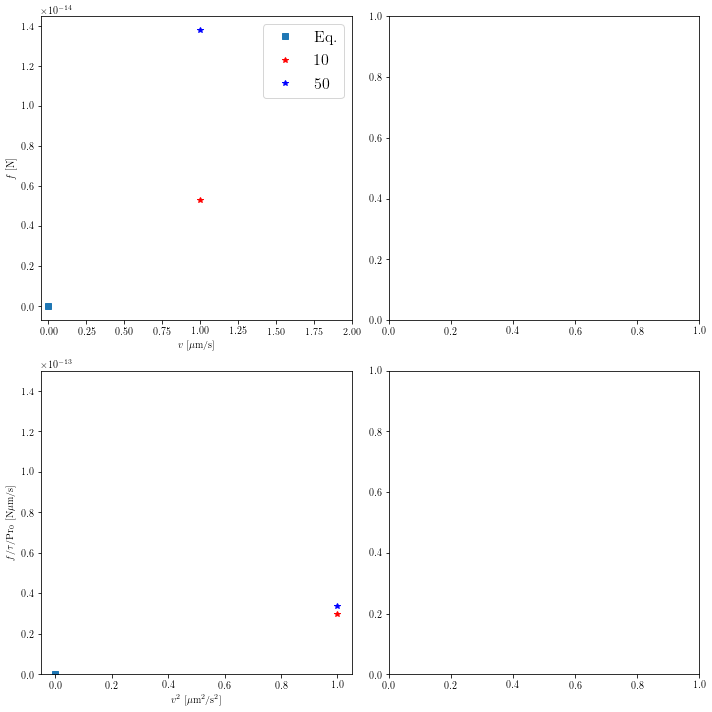

In [11]:
# plot grapיs for multiple taus
import itertools
%matplotlib inline
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize = (10,10))
colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm'])
tau_array = np.sort(1/pd.unique(DataSummary['D_R_Ps']))
FitNormalizedForceCurve = False
# tau_array = tau_array[:-1]
AllDFforPlot = pd.DataFrame()
if 1: # plot equilibrium
    kT = 4.11 * 10**(-21)
    ax[0,0].plot(0, 0, 's' ,label = 'Eq.')
    ax[1,0].plot(0, 0, 's' ,label = 'Eq.')
for tau in tau_array:
    color = next(colors)
    DFforPlot = DataSummary.loc[DataSummary['tau_s'] == tau]
    if 1: # 0,0: force vs. v
        label = str(int(DFforPlot['tau_s'].values[0]))
        ax[0,0].plot(DFforPlot['velocity_umPs'], DFforPlot['AverageForceLeft_N'] , '*', label = label, color = color)
        ax[0,0].legend(fontsize = 16)
        ax[0,0].set_ylabel('$f$ [N]')
        ax[0,0].set_xlabel('$v$ [$\mu$m/s]')
        ax[0,0].set_xlim(right = 2)
    if 1: # 1,0: normalized forces
        ax[1,0].plot(DFforPlot['velocity_umPs']**2, DFforPlot['Force_Norm'], '*', label = label, color = color)
        # ax[1,0].plot(0,0,'x')
        ax[1,0].set_ylabel('$f/\\tau/\mathrm{Pr_0}$ [N$\mu$m/s]')
        ax[1,0].set_xlabel('$v^2$ [$\mu$m$^2$/s$^2$]')   
        ax[1,0].set_ylim([0,1.5E-13])         
    if 0: # 1,1: Plot maximal forces
        ax[1,1].plot(DFforPlot['V_mean_um'], DFforPlot['MaximalForce_N'],'o', color = color)
        ax[1,1].set_xlim(right = 2)
        ax[1,1].set_ylabel('$f_{\mathrm{max}}$ [N]')
        ax[1,1].set_xlabel('$v$ [$\mu$m/s]') 
    AllDFforPlot = pd.concat([AllDFforPlot,DFforPlot])
if FitNormalizedForceCurve: # 0,1: fit curve to normalized data
    popt = FitToLinearCurve(AllDFforPlot['velocity_umPs']**2, AllDFforPlot['Force_Norm'], plotFlag=False)
    x = np.linspace(0,AllDFforPlot['velocity_umPs'].max()**2, 40)
    y = popt[0] * x + popt[1]
    NormalizedForceSlope = popt[0]
    ax[1,0].plot(x,y,'k')
    print('Drag from normalized force profile (2 x slope) is: ', '{:0.1e}'.format(NormalizedForceSlope*2), 'Ns/ \mu m')

if 0: # 1,1: fit curve to maximal force
    x, y = AllDFforPlot['V_mean_um'], AllDFforPlot['MaximalForce_N']
    func = lambda x,p: p*x;
    popt, pcov=curve_fit(func, x, y)
    # popt = FitToLinearCurve(x, y, plotFlag=False)
    x_new = np.linspace(0,SummaryTable['V_mean_um'].max(), 40)
    y_new = func(x_new, *popt)
    MaxForceSlope = popt[0]
    ax[1,1].plot(x_new,y_new,'k')
# print('Drag from maximal force (slope) is: ', '{:0.1e}'.format(MaxForceSlope), 'Ns/ \mu m')
fig.tight_layout()

In [ ]:
DO NOT FORGET FORCE FACTOR!!!!

In [668]:
# %matplotlib inline
# %matplotlib inline

# See orientations

In [40]:
subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\FitDrag_movie' # agrees with theory P, as long as low persistence length compared to bulk
# subFolder=r'20190926_HMDS_AF_tau_SDS_Relay\LargeCellHarmonicFinitePotential' 
# subFolder=r'20190926_HMDS_AF_tau_SDS_Relay\LargerCellHarmonicFinitePotential' 
# subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\FitDrag_Traj'
subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\ShortRun5fps' #  - PAPER
subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\InteractingPartcls'

subFolder = Path(subFolder)
print(subFolder.is_dir())
subFolder

True


WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls')

In [71]:
### 20190926_HMDS_AF_tau_SDS_Relay\ShortRun5fps - PAPER
# ShortFilename = r'Sim_V_8_vel_1p5_Dt_0p1_C_1_Dr_0p005_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv' # yep
# ShortFilename = r'Sim_V_8_vel_2_Dt_0p1_C_1_Dr_0p005_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv' # yep
# ShortFilename = r'Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p002_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
ShortFilename = r'Sim_V_8_vel_2_Dt_0p1_C_1_Dr_0p01_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv' # yep
# ShortFilename = r'Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p005_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_2_Dt_0p1_C_1_Dr_0p02_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p01_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p05_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv' # yep
# ShortFilename = r'Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p005_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv' # yep

### 20190926_HMDS_AF_tau_SDS_Relay\FitDrag_Traj
# ShortFilename = r'Sim_V_8_vel_2_Dt_0p1_C_1_Dr_0p01_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_2_Dt_0p1_C_1_Dr_0p005_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1p5_Dt_0p1_C_1_Dr_0p005_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'


### FitDrag_movie
# ShortFilename = r'Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p005_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_3p5_Dt_0p1_C_1_Dr_0p005_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'

### LargeCellHarmonicFinitePotential
# ShortFilename =r'Sim_V_8_vel_2_Dt_0_C_1_Dr_0p01_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1_Dt_0_C_1_Dr_0p002_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1_Dt_0_C_1_Dr_0p05_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'
### LargerCellHarmonicFinitePotential
# ShortFilename =r'Sim_V_8_vel_2_Dt_0_C_1_Dr_0p0_NumPrtcls_1_dragFactorToPsv_1p82_coords.csv'

### 20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls
ShortFilename = r'Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dragFactorToPsv_1p82_coords.csv'

In [158]:
def readSimulationCoords(subFolder, ShortFilename, velDiff, fps, StartingStep = 200, PlotProfile = True):
    # load files:
    FullPathTrajFilename = subFolder/ShortFilename
    MetafileShortFilename = ShortFilename.replace('coords', 'MetaData')
    FullPathMetaFilename = subFolder/MetafileShortFilename    
    try:
        LoadedMetaDF = pd.read_csv(FullPathMetaFilename, index_col = False)
    except:
        print('Failed to load Metafile', FullPathMetaFilename)
        if FullPathMetaFilename.is_file(): 
            print('File exists') 
        else: 
            print('File does not exists')
        return None
    try:
#         CoordsDF_infnc = pd.read_csv(FullPathTrajFilename, delimiter=',', index_col = False, 
#                         usecols = [0,1,2], names = ['theta', 'x', 'y'], skiprows = StartingStep) # because it works fast and does not use RAM
        CoordsDF_infnc = pd.read_csv(FullPathTrajFilename, delimiter=',', index_col = False, 
                                     skiprows = StartingStep) # because it works fast and does not use RAM
        
    except:
        print('Failed to load Datafile', FullPathTrajFilename)
        if FullPathTrajFilename.is_file(): 
            print('File exists')
        else: 
            print('File does not exists')
    
#     NumOfParticles = len(CoordsDF_infnc.columns)//3
    NumOfParticles = LoadedMetaDF['NumberOfParticles']
    columnNames = list()
    for i in range(NumOfParticles):
        ParticleNamesCols = ['theta_'+str(i), 'x_'+str(i), 'y_'+str(i)]
        columnNames.extend(ParticleNamesCols)
    CoordsDF_infnc.columns = columnNames
    
    if 'dt_betweenProfilePoints_s' in LoadedMetaDF.columns:
        fps = 1/LoadedMetaDF['dt_betweenProfilePoints_s'].values[0]
        print('fps overwritten according to metadata from simulation: ', fps)
    
    # add displacement columns
    for i in range(NumOfParticles):
        prtclName = str(i)
        CoordsDF_infnc['dx_' + prtclName] = np.nan
        CoordsDF_infnc['dy_' + prtclName] = np.nan
        CoordsDF_infnc['dx_' + prtclName][velDiff:] = (CoordsDF_infnc['x_' + prtclName][velDiff:].values - CoordsDF_infnc['x_' + prtclName][:-velDiff].values)/velDiff
        CoordsDF_infnc['dy_' + prtclName][velDiff:] = (CoordsDF_infnc['y_' + prtclName][velDiff:].values - CoordsDF_infnc['y_' + prtclName][:-velDiff].values)/velDiff
        CoordsDF_infnc['v_x_um_' + prtclName] = CoordsDF_infnc['dx_' + prtclName] * fps
        CoordsDF_infnc['v_y_um_' + prtclName] = CoordsDF_infnc['dy_' + prtclName] * fps
    
    # plot profile:
    if PlotProfile:
        fig, ax = plt.subplots(1, figsize = (12,7))
        StrideForHistogram = 5
        ax.hist(CoordsDF_infnc['y_' + prtclName][::StrideForHistogram], bins = 500, density = 'norm');
        print('WARNING: Histogram plotted with on particle trajectory only, with stride ', StrideForHistogram)

    return CoordsDF_infnc, LoadedMetaDF

In [151]:
%matplotlib inline
%matplotlib inline

fps overwritten according to metadata from simulation:  1.0


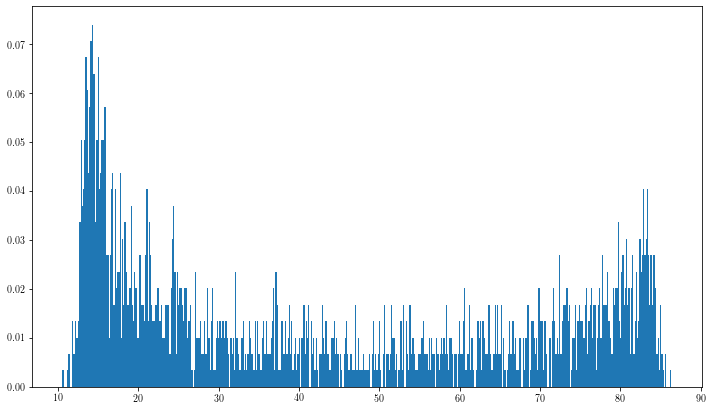

In [159]:
fps = 5
velDiff = 2
CoordsDF, LoadedMetaDF = readSimulationCoords(subFolder, ShortFilename, velDiff, fps)

## Optional: Reproduce Experimental curves (NOT simulation data analysis)

101


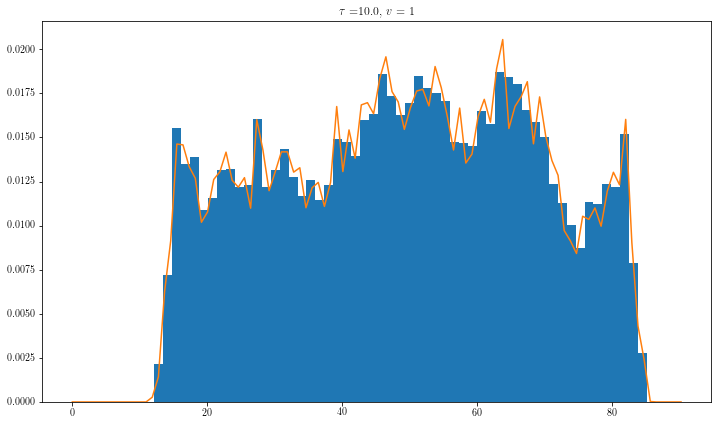

In [65]:
# np.random.seed(45)
bw_method = 0.01
ExpParticleNum = str(int(1/LoadedMetaDF['D_R_Ps'].values[0])) + str(np.round(LoadedMetaDF['velocity_umPs'].values[0], 2)).replace('.', 'p')
SampleEvery = 1
TrajStart_ind = 0

fig, ax = plt.subplots(1, figsize = (12,7))
ExpCurve = CoordsDF[TrajStart_ind::SampleEvery].copy()

ExpCurve['y'] = ExpCurve['y'] + 0 * (np.random.rand(len(ExpCurve['y']))-0.5)
print(ExpParticleNum)
kde = gaussian_kde(ExpCurve['y'],bw_method=bw_method)
X_grid_length = 100
distance_grid=np.linspace(0,ExpCurve['y'].max() + 5,X_grid_length) 
KDE_DistanceDistribution=(kde.evaluate(distance_grid))
tau = 1/LoadedMetaDF['D_R_Ps'].values[0]
# ExpCurve['y']
ax.hist(ExpCurve['y'], bins = 55, density = 'norm');
ax.plot(distance_grid, KDE_DistanceDistribution);
ax.set_title(r'$\tau = $' + str(tau) + ', $v$ = ' + str(LoadedMetaDF['velocity_umPs'].values[0]));

In [879]:
# ExpFolder = Path(subFolder)/'Experiment'
ExpFolder = Path(r'C:\Users\M\Python3TrackpyFolderNotebooks\20190926_HMDS_AF_tau_SDS_Relay_results\AllSymAvgs')
Path.mkdir(ExpFolder, exist_ok=True)

In [880]:
# add velocity to traj
def AddDiffVelColumns(traj, fps, SampleEvery):
# produce vel diff
    for velDiff in range(1,5):
        traj['dx'] = np.nan
        traj['dy'] = np.nan
        traj['dx'][velDiff:] = (traj['x'][velDiff:].values - traj['x'][:-velDiff].values)/velDiff
        traj['dy'][velDiff:] = (traj['y'][velDiff:].values - traj['y'][:-velDiff].values)/velDiff
        traj['v_x_' + str(velDiff)] = traj['dx'] * fps
        traj['v_y_' + str(velDiff)] = traj['dy'] * fps
    return traj
fps = 1/LoadedMetaDF['SamplingTimeForCoordsFile_s'].values[0]/SampleEvery
ExpCurve = AddDiffVelColumns(ExpCurve, fps, SampleEvery)
ExpCurve.head()

,theta,x,y,dx,dy,v_x_um,v_y_um,v_x_1,v_y_1,v_x_2,v_y_2,v_x_3,v_y_3,v_x_4,v_y_4
0,0.296739,24.565268,75.670773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.269146,25.127348,75.472579,NaN,NaN,NaN,NaN,2.810395,-0.990973,NaN,NaN,NaN,NaN,NaN,NaN
2,0.252152,25.848080,75.490660,NaN,NaN,3.207029,-0.450284,3.603663,0.090405,3.207029,-0.450284,NaN,NaN,NaN,NaN
3,0.264064,26.024050,75.842428,NaN,NaN,2.241756,0.924623,0.879850,1.758841,2.241756,0.924623,2.431303,0.286091,NaN,NaN
4,0.335497,26.373075,75.832760,0.451952,0.040497,1.312486,0.855250,1.745123,-0.048342,1.312486,0.855250,2.076212,0.600302,2.259758,0.202483


In [869]:
# create datafile names for export
TrajFilename = 'tau' + str(int(tau)) +'_AvgSym2_AvgPrtcl_PrtclNum_'+ ExpParticleNum + '_Traj.xlsx'
ProbabilityFilenamen = 'tau' + str(int(tau)) +'_AvgSym2_AvgPrtcl_PrtclNum_'+ ExpParticleNum + '_ProbProfile.csv'
MetadataFilename = 'tau' + str(int(tau)) +'_AvgSym2_AvgPrtcl_PrtclNum_'+ ExpParticleNum + '_MetaData.csv'
ExpFolder.absolute()

WindowsPath('C:/Users/M/Python3TrackpyFolderNotebooks/20190926_HMDS_AF_tau_SDS_Relay_results/AllSymAvgs')

In [870]:
# Export Metafile
DictMetaFile = dict()
DictMetaFile = {"V_mean_um": LoadedMetaDF['velocity_umPs'].values[0], "V_std_um": 0.75426918, 
                "ParticleNum": ExpParticleNum, "tau": tau, "DEP_vpp": 8, "Origin": 'sim', 
                "OriginFilename": LoadedMetaDF['filenameBase'].values[0], 
                'fps_Traj_file': 1/LoadedMetaDF['SamplingTimeForCoordsFile_s'].values[0]}
# export metadata
with open(ExpFolder/MetadataFilename, 'w') as file:
    for x in DictMetaFile.keys(): 
        file.write(str(x)+',')
    file.write('\n')
with open(ExpFolder/MetadataFilename, 'a') as file:
    for x in DictMetaFile.values(): 
        file.write(str(x)+',')
    file.write('\n')
ExpFolder/MetadataFilename

WindowsPath('C:/Users/M/Python3TrackpyFolderNotebooks/20190926_HMDS_AF_tau_SDS_Relay_results/AllSymAvgs/tau200_AvgSym2_AvgPrtcl_PrtclNum_2001p5_MetaData.csv')

In [871]:
# Export Probability profile
ProbDF = pd.DataFrame(data = np.vstack([distance_grid, KDE_DistanceDistribution]).T, columns = ['d1_um', 'Prob1'])
ProbDF.to_csv(ExpFolder/ProbabilityFilenamen)
ExpFolder/ProbabilityFilenamen

WindowsPath('C:/Users/M/Python3TrackpyFolderNotebooks/20190926_HMDS_AF_tau_SDS_Relay_results/AllSymAvgs/tau200_AvgSym2_AvgPrtcl_PrtclNum_2001p5_ProbProfile.csv')

In [872]:
# Export trajectory
ExportTraj = ExpCurve.copy()
dt_betweenProfilePoints_s = LoadedMetaDF['dt_betweenProfilePoints_s'].values[0]
dt_s_simulation = LoadedMetaDF['dt_s'].values[0]
dt_s_export = SampleEvery * dt_betweenProfilePoints_s
fps_export = 1/dt_s_export
ExportTraj['frame'] = np.linspace(0, (len(ExportTraj)-1)/ fps_export *5 , len(ExportTraj)).astype('uint')
ExportTraj['x_driftCorr'] = 0
ExportTraj['y_driftCorr'] = 0
ExportTraj['Distance'] = ExportTraj['y']
ExportTraj['Yvel_umPs'] = ExportTraj['v_y_um'] 
ExportTraj['Xvel_umPs'] = ExportTraj['v_x_um'] 
ExportTraj['Vel_umPs'] = np.sqrt(ExportTraj['Yvel_umPs']**2 + ExportTraj['Xvel_umPs']**2)
ExportTraj['Time_s'] = LoadedMetaDF['dt_s']
ExportTraj.to_csv(ExpFolder/TrajFilename)
ExpFolder/TrajFilename

WindowsPath('C:/Users/M/Python3TrackpyFolderNotebooks/20190926_HMDS_AF_tau_SDS_Relay_results/AllSymAvgs/tau200_AvgSym2_AvgPrtcl_PrtclNum_2001p5_Traj.xlsx')

## Orientations maps from simulation coordinates

Use a Legendre polynomial as order parameter:

In 3D: S = $\left<\frac{3\cos^2 \theta -1}{2}\right>$

In 2D: S = $2\left<\cos^2 \theta -1\right>$ = $\left<\cos 2\theta\right>$

In [218]:
def CalculatePlotAndExportPolarizationMaps(CoordsDF, LoadedMetaDF, DistancesToSampleArray, subFolder, ShortFilename,
                                           SamplingWidth_um = 2, ExportImage = False, LimitVelocityForPlot = None):
    fig, ax = plt.subplots(4, len(DistancesToSampleArray), figsize = [16,22])
    print('Note: for simulations mimicking 20190926_HMDS_AF_tau_SDS_Relay, center at 48.8')
    range_um = SamplingWidth_um
    Swimming_velocity = LoadedMetaDF['velocity_umPs'][0]
    Is_LimitVelocityForPlot_number = (isinstance(LimitVelocityForPlot, float) | isinstance(LimitVelocityForPlot, int))
    NumOfParticles = LoadedMetaDF['NumberOfParticles'][0]
    if not Is_LimitVelocityForPlot_number:
        LimitVelocityForPlot = Swimming_velocity * 1.8
    for ind, DistanceToSample in enumerate(DistancesToSampleArray):
        MaxDistance = DistanceToSample + range_um/2
        MinDistance = DistanceToSample - range_um/2
        valid_vy = np.array([])
        valid_vx = np.array([])
        valid_theta = np.array([])

        for prtclNum in range(NumOfParticles):
            prtclName = str(prtclNum)
            Sampling_segment_bool = CoordsDF['y_' + prtclName].between(MinDistance, MaxDistance)
#             import pdb; pdb.set_trace()
            valid_vx = np.concatenate((valid_vx, CoordsDF.loc[Sampling_segment_bool]['v_x_um_' + prtclName].values))
            valid_vy = np.concatenate((valid_vy, CoordsDF.loc[Sampling_segment_bool]['v_y_um_' + prtclName].values))
            valid_theta = np.concatenate((valid_theta, CoordsDF.loc[Sampling_segment_bool]['theta_' + prtclName].values))

#             ax[0,ind].hist2d(CoordsDF.loc[Sampling_segment_bool]['v_x_um'], CoordsDF.loc[Sampling_segment_bool]['v_y_um']
#             ax[1, ind].scatter(CoordsDF.loc[Sampling_segment_bool]['v_x_um'], CoordsDF.loc[Sampling_segment_bool]['v_y_um']
#             ax[2,ind].scatter(Swimming_velocity*np.cos(CoordsDF.loc[Sampling_segment_bool]['theta'][::3]), 
#                             Swimming_velocity*np.sin(CoordsDF.loc[Sampling_segment_bool]['theta'][::3]),
#           ax[3,ind].hist(np.mod(CoordsDF.loc[Sampling_segment_bool]['theta'], 2*np.pi)*180.0/np.pi,
                         
                         
        if 1: # first panel displacements scatter
            if ((DistanceToSample<60) & (DistanceToSample>40)):
                alpha = 1
            else:
                alpha = 1
            ax[0,ind].hist2d(valid_vx, valid_vy,
                             bins = 50, cmap = 'jet', 
                             range = [[-LimitVelocityForPlot, LimitVelocityForPlot], [-LimitVelocityForPlot, LimitVelocityForPlot]], 
                             density = True)
            print((np.cos(2* valid_theta)).mean())
            print((np.sin(2* valid_theta)).mean())
        if False: # second panel heatmap displacements
            ax[1, ind].scatter(valid_vx, valid_vy, color= 'r')
        # set legends for panels 1, 2
        for panel in list([0,1]):
            ax[panel,ind].set_xlim([-LimitVelocityForPlot,LimitVelocityForPlot])
            ax[panel,ind].set_ylim([-LimitVelocityForPlot,LimitVelocityForPlot])
            ax[panel,ind].set_xlabel('$\dot{x}[\mu$m/s]')
            ax[panel,ind].set_ylabel('$\dot{y}[\mu$m/s], $\\bot$wall')
            ax[panel,ind].set_aspect('equal', adjustable='box')
            ax[panel,ind].set_title('$d$ = ' + str(np.round(DistanceToSample)) + '[$\mu$m]')
        if False: # third panel with driving swimming direction
            alpha = 1
            
            ax[2,ind].scatter(Swimming_velocity*np.cos(valid_theta[::20]), 
                            Swimming_velocity*np.sin(valid_theta[::20]),
                            alpha = alpha, color= 'r')
            ax[2,ind].set_xlim([-1.1*Swimming_velocity,1.1*Swimming_velocity])
            ax[2,ind].set_ylim([-1.1*Swimming_velocity,1.1*Swimming_velocity])
            ax[2,ind].set_xlabel('$u_x[\mu$m/s]')
            ax[2,ind].set_ylabel('$u_y[\mu$m/s], $\\bot$wall')
            ax[2,ind].set_aspect('equal', adjustable='box')
            ax[2,ind].set_title('$d$ = ' + str(np.round(DistanceToSample)) + '[$\mu$m]')
        if 4: # panel 4, histogram for theta degrees
            bins = 400
            ax[3,ind].hist(np.mod(valid_theta, 2*np.pi)*180.0/np.pi, 
                           bins = bins, density = True)
            ax[3,ind].set_xlabel(r'$\theta$')
            ax[3,ind].set_ylabel('Probability')
            ax[3,ind].set_xticks([0, 90, 180, 270, 360])
    tau = 1/LoadedMetaDF['D_R_Ps'][0]
    fig.suptitle('$v$ = ' + str(Swimming_velocity) + ' , $\\tau$ = ' + str(tau) + 
                 ', $H = $' + str(LoadedMetaDF.ChannelLength_um.values[0])) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    if ExportImage:
        CurrentFolder = Path(subFolder)
        FullPathTrajFilename = CurrentFolder/ShortFilename
        exportFilename = Path(str(FullPathTrajFilename).replace('coords.csv', '.jpg'))
        fig.savefig(exportFilename, dpi = 500)
        print(exportFilename)

Note: for simulations mimicking 20190926_HMDS_AF_tau_SDS_Relay, center at 48.8
0.11497110916663617
0.019967407074833826
0.11497110916663617
0.019967407074833826


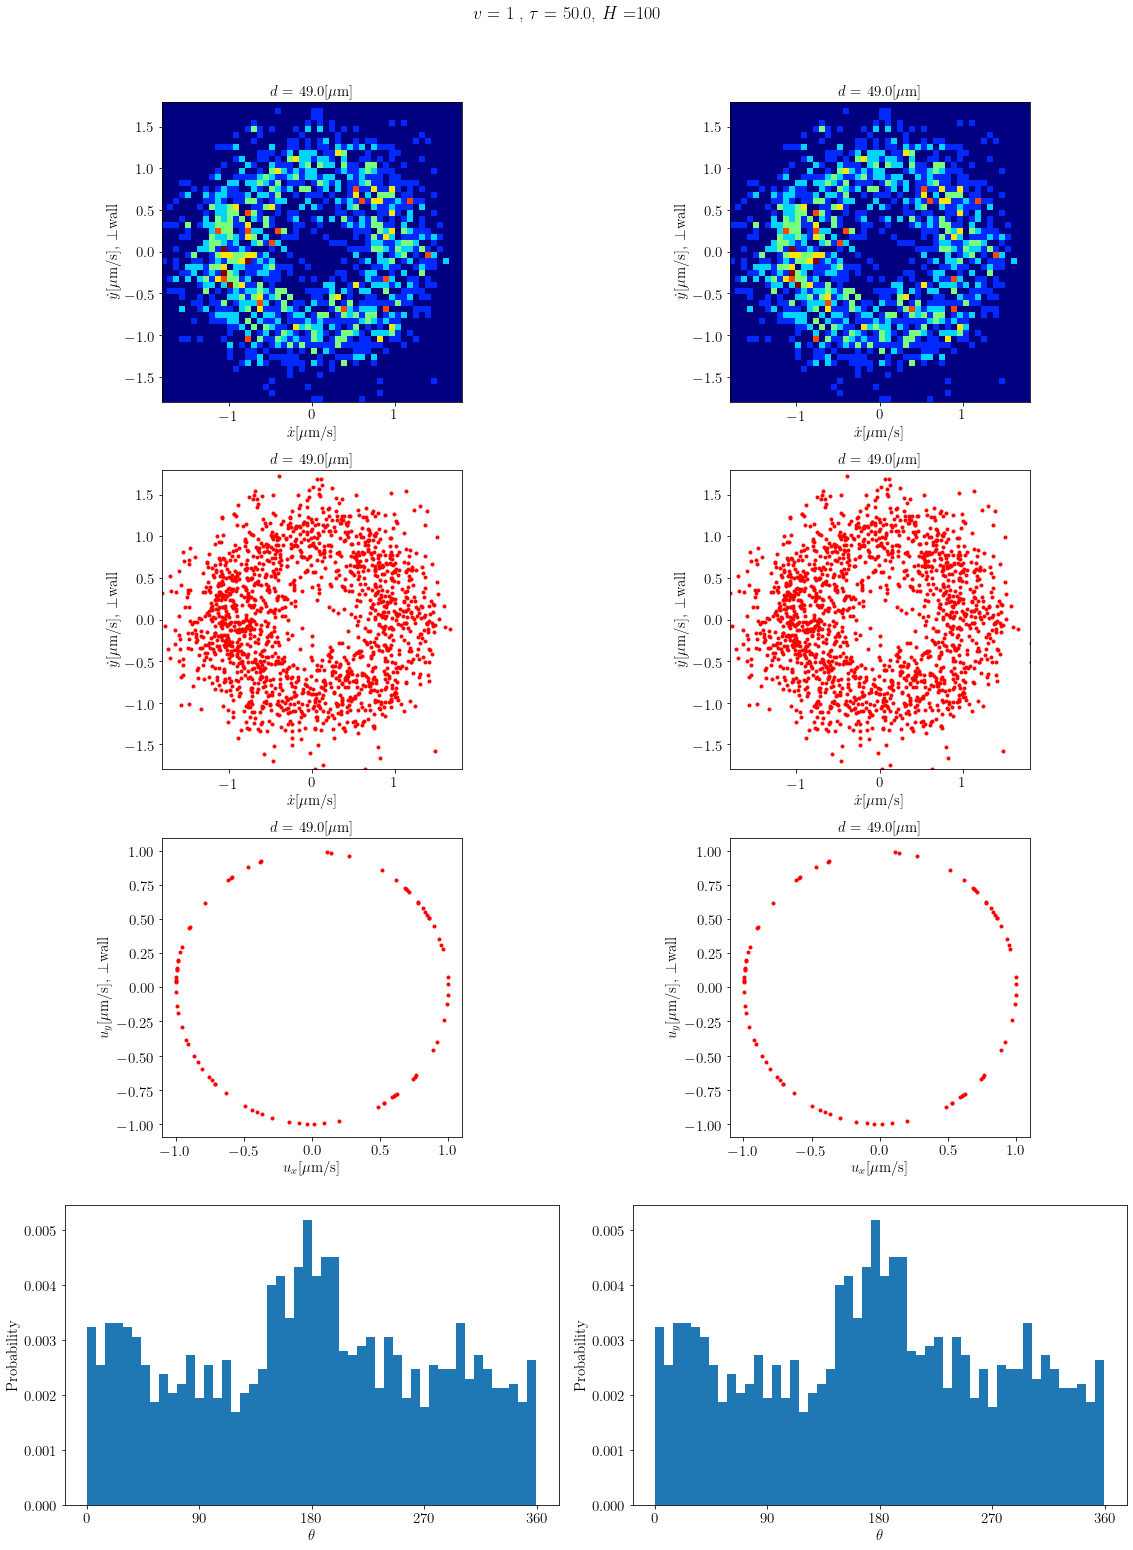

In [219]:
latexify(fig_height = 3.5, fontsize= 15)
# DistancesToSampleArray = [48.8-40, 48.8, 48.8+40] # 51,18,82
# DistancesToSampleArray = [48.8-33,48.8,48.8+33]
DistancesToSampleArray = [48.8, 48.8]
SamplingWidth_um = 2
ExportImage = False
CalculatePlotAndExportPolarizationMaps(CoordsDF, LoadedMetaDF, DistancesToSampleArray, subFolder, ShortFilename, 
                                           SamplingWidth_um = SamplingWidth_um, ExportImage = ExportImage)

## OPTIONAL: export to images all coords in a folder

In [106]:
fps = 0.5
velDiff = 2
DistancesToSampleArray = [15,50,85]
SamplingWidth_um = 2
print(CurrentFolder)
ListOfAllCoordsFilesInFolder = glob.glob(CurrentFolder+'/*_coords.csv')
for filename in tqdm(ListOfAllCoordsFilesInFolder):
    ShortFilename = filename.split('\\')[-1]
    CoordsDF, LoadedMetaDF = readSimulationCoords(subFolder, ShortFilename, velDiff, fps, PlotProfile = False)
    CalculatePlotAndExportPolarizationMaps(CoordsDF, LoadedMetaDF, DistancesToSampleArray, subFolder, ShortFilename, 
                                               SamplingWidth_um = SamplingWidth_um, ExportImage = True)

C:\Users\M\PycharmProjects\Simulation


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Failed to load Metafile C:\Users\M\PycharmProjects\Simulation\20190926_HMDS_AF_tau_SDS_Relay\FitDrag_Traj\Sim_V_7_vel_2_Dt_0p1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1_MetaData.csv


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not iterable

# Order parameter from experiment (order parameter files, not coords)

I could also retrieve this from the trajectories. If I do that, I will actually be able to get the average theta as well. I can also fix the code to calculate things more correctly:

$N\left<\theta_0 \right> = \large{\Sigma} \small{(\theta \% \pi) / 2}$

$N\left<\cos\theta \right> = \large{\Sigma} \small{(\cos\theta \% \pi) / 2}$

$N\left<\sin\theta \right> = \large{\Sigma} \small{(\sin\theta \% \pi) / 2}$


In [162]:
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan'
subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScanNoDiffusion' # used in the paper as experiment
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan_highVel'
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\LargeCellHarmonicFinitePotential'
# subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\FitDrag_Traj'
# subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\ShortRun5fps' # used in experiments for paper
# subFolder = r'20190926_HMDS_AF_tau_SDS_Relay\VeryLong_l_p'

CurrentFolder=os.getcwd()
CurrentFolder=CurrentFolder.replace('\\',r'/')+'/'+subFolder

In [163]:
print(CurrentFolder)
filelistMeta=glob.glob(CurrentFolder+'/*MetaData.csv')
filelistPDF=glob.glob(CurrentFolder+'/*PDfunc.csv')
filelistOrderParam=glob.glob(CurrentFolder+'/*OrderParam.csv')
DataSummary=pd.DataFrame()
for filename in filelistMeta:
    DataSummary=DataSummary.append(pd.read_csv(filename,index_col=False))
DataSummary['tau_s'] = 1/DataSummary['D_R_Ps']
DataSummary['Force_Norm'] = DataSummary['AverageForceLeft_N']/DataSummary['tau_s']/DataSummary['ProbAtCenter']
print('Voltages:', np.sort(pd.unique(DataSummary['ActiveVoltage'])))
print('Velocities:',np.sort(pd.unique(DataSummary['velocity_umPs'])))
print('D_R:',np.sort(pd.unique(DataSummary['D_R_Ps'])))
print('Number Of particles:',np.sort(pd.unique(DataSummary['NumberOfParticles'])))
print('Drag multipliers', np.sort(pd.unique(DataSummary['drag_multiplier'])))
print('Torque ratio C', np.sort(pd.unique(DataSummary['C_ratio_dlctrc_cnst'])))

C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\OrderParamScanNoDiffusion
Voltages: [8]
Velocities: [0.2  0.5  0.75 1.   1.25 1.5  1.75 2.  ]
D_R: [0.005      0.00625    0.0075     0.00875    0.01       0.015
 0.0175     0.02       0.025      0.03       0.035      0.0375
 0.04       0.05       0.0625     0.06666667 0.075      0.0875
 0.1        0.125      0.15       0.16666667 0.175      0.2
 0.25       0.3        0.33333333 0.35       0.4        0.41666667
 0.5        0.58333333 0.66666667]
Number Of particles: [100]
Drag multipliers [1.82]
Torque ratio C [1]


In [164]:
if 1: # join DataSummary with the order parameter data at different distances, imported from file. 
    # Take variables of interst from Datasummary
    OrderParamDF = DataSummary[['filenameBase', 'velocity_umPs','tau_s', 
                                'Force_Norm','AverageForceLeft_N','ProbAtCenter','drag_N_sPum']]
    # import all the S data from files
    OrderParamDF_to_add_DF = pd.DataFrame()
    for filenameBase in DataSummary['filenameBase'].values[:]: 
            OrderParam_filename = CurrentFolder+'/'+filenameBase+('_OrderParam.csv')
            OrderParamSingleExpDF = pd.read_csv(OrderParam_filename, index_col= False, names = ['d_um','OrderParam','Counts'])
            OrderParamSingleExpDF['filenameBase'] = filenameBase
            OrderParamDF_to_add_DF = pd.concat([OrderParamDF_to_add_DF, OrderParamSingleExpDF])    
    
    # merge the two DFs: 
    OrderParamDF = OrderParamDF_to_add_DF.merge(OrderParamDF, on = 'filenameBase')
    OrderParamDF['Persistence_length_um'] = np.round(OrderParamDF['tau_s'] * OrderParamDF['velocity_umPs'] , 1)
    # print some 
    print('d_um ' + str(pd.unique(OrderParamDF['d_um'])))
    print('tau  ' + str(pd.unique(OrderParamDF['tau_s'])))
    print('v    ' + str(pd.unique(OrderParamDF['velocity_umPs'])))
    print('l_p    ' + str(pd.unique(OrderParamDF['Persistence_length_um'])))
    # print('D_R:' + str(pd.unique(DataSummary['D_R_Ps'])))

d_um [ 8.8 18.8 28.8 38.8 48.8 58.8 68.8 78.8 88.8]
tau  [100.          50.          25.          15.          40.
  20.           6.          10.         133.33333333  66.66666667
  26.66666667  13.33333333   6.66666667   4.         160.
  16.           8.           2.4         33.33333333   3.33333333
   2.         114.28571429  57.14285714  28.57142857  11.42857143
   5.71428571   2.85714286   1.71428571 200.           5.
   3.           2.5          1.5       ]
v    [0.2  0.5  0.75 1.25 1.5  1.75 1.   2.  ]
l_p    [ 20.  10.   5.   3.  50. 100. 200.]


In [165]:
%matplotlib inline
%matplotlib inline

In [167]:
plt.rcParams['lines.linewidth']

1.5

Saved. C:\Users\M\Dropbox\ActiveMatterPaper\Figures\Results3


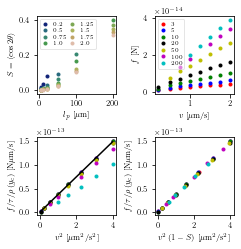

In [174]:
## Plot S vs. v [tau legend] at different distances. 
latexify(fig_height = 3.5)
# latexify(fig_width = 5, fig_height = 5)

DistancesToPlot = 48.8
# DistancesToPlot = [18.8, 50]

alphaLegend = 0.5
# Tau_ToPlot_in_legend = np.sort(pd.unique(OrderParamDF['tau_s'].values))
Tau_ToPlot_in_legend = Tau_ToPlot_in_legend[Tau_ToPlot_in_legend % 2 == 0]
L_p_ToPlot_in_F_vs_v_squared = pd.unique(OrderParamDF['Persistence_length_um']) # [10, 20, 50, 75, 100, 150, 125, 200, 225]
# L_p_ToPlot_in_F_vs_v_squared = [20, 100, 200, 150, 225, 375]
# L_p_ToPlot_in_F_vs_v_squared = [3,5,10,20, 100, 200]
# L_p_ToPlot_in_F_vs_v_squared = [3,5,10,20]

saveToPaperFolder = True
colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm','c'])
if 1: 
    from matplotlib import cm
    tau_list = Tau_ToPlot_in_legend
    fig, ax = plt.subplots(2,2)
    if 1: # 1st panel: S(l_p) legend velocity
        for velocity in velocities:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['velocity_umPs'] == velocity)]
            label = r'$v$ = ' + str(velocity)
            label = str(velocity)
            color = cm.gist_earth(int(254 * 0.9 * (velocity/velocities.max())))
            ax[0,0].plot(DFforPlot['Persistence_length_um'], DFforPlot['OrderParam'], 'o', 
                         label = label, color = color)
        ax[0,0].legend(framealpha = alphaLegend, ncol= 2)
        # ax[0,0].set_title('$d$ = ' + str(distance))
        ax[0,0].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[0,0].set_xlabel(r'$l_p$ [$\mu$m]')
    if 1: # 2nd panel : force vs. velocity, legend l_p
        l_p_list = np.unique(np.sort(L_p_ToPlot_in_F_vs_v_squared))
        colors =  itertools.cycle(["r", "b", "g", 'k', 'y', 'm','c'])
        for l in l_p_list:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
            label =  str(int(l))
            color = next(colors)
            ax[0,1].plot(DFforPlot['velocity_umPs'], DFforPlot['AverageForceLeft_N'], 'o', 
                         label = label, color = color)
            
        ax[0,1].set_ylabel(r'$f$ [N]')
        ax[0,1].set_xlabel(r'$v$ [$\mu$m/s]')
        ax[0,1].legend(framealpha = alphaLegend)
    if 0: # 3rd panel, Unitless force/force bulk theory
        for tau in tau_list:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['tau_s'] == tau)]
            label = str(np.round(tau,1))
            UnitlessForce = 2*DFforPlot['Force_Norm']/(DFforPlot['velocity_umPs']**2)/DFforPlot['drag_N_sPum']
            color = cm.gist_earth(int(254 * 0.9 * 
                                      (tau/tau_list.max()+0)))
            ax[1,0].plot(DFforPlot['Persistence_length_um'], UnitlessForce, 'o', 
                                   markersize = 12, label = label, color = color)
        ax[1,0].legend(fontsize = 20, framealpha = alphaLegend, ncol = 2, title=r"$\tau$ [s]")
        ax[1,0].set_title(r'$d$ = ' + str(distance))
        ax[1,0].set_ylabel(r'$2f\mu/\tau/\rho\left(y_\mathrm{c}\right)/v^2 $')
        ax[1,0].set_xlabel(r'$l_p$ [$\mu$m]')
    if 1: # 3rd panel, right: force theory:
        for l in l_p_list:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
            label = str(l)
            color = next(colors)
            ax[1,0].plot(DFforPlot['velocity_umPs']**2, DFforPlot['Force_Norm'], 'o', 
                         label = label, color = color)
        ax[1,0].set_ylabel(r'$f/\tau/\rho\left(y_\mathrm{c}\right)$ [N$\mu$m/s]')
        ax[1,0].set_xlabel(r'$v^2$ [$\mu$m$^2$/s$^2$]')
        ax[1,0].legend(framealpha = alphaLegend)
        ax[1,0].plot(OrderParamDF['velocity_umPs']**2, 0.5*OrderParamDF['drag_N_sPum']*OrderParamDF['velocity_umPs']**2, 'k', label = 'Theory')
    if 1: # 4th panel, renormalized f vs. v^2
        l_p_list = np.sort(L_p_ToPlot_in_F_vs_v_squared);
        colors =  itertools.cycle(["r", "b", "g", 'k', 'y', 'm','c'])
        for l in l_p_list:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
            label = '$l_p$ = ' + str(l)
            label = str(l)
            color = next(colors)
            ax[1,1].plot((DFforPlot['velocity_umPs']**2)*(1-DFforPlot['OrderParam']), DFforPlot['Force_Norm'], 'o', 
                         label = label, color = color)
        ax[1,1].set_ylabel(r'$f/\tau/\rho\left(y_\mathrm{c}\right)$ [N$\mu$m/s]')
        ax[1,1].set_xlabel(r'$v^2 \left(1-S\right)$ [$\mu$m$^2$/s$^2$]')
        ax[1,1].legend(framealpha = alphaLegend, ncol =2, title=r"$l_p$ [$\mu$m]")
        # ax[4,1].plot(OrderParamDF['velocity_umPs']**2, 0.5*OrderParamDF['drag_N_sPum']*OrderParamDF['velocity_umPs']**2, 'k', label = 'Theory')
    # general tidying
    ax[1,0].legend([], frameon = False)
    ax[1,1].legend([], frameon = False)
    fig.tight_layout()
    # fig.suptitle(subFolder.split('\\')[1]) 
    # fig.subplots_adjust(top=0.95)
    
    if saveToPaperFolder:
        folderPath = Path(r"C:\Users\M\Dropbox\ActiveMatterPaper\Figures\Results3")
        folderPath.mkdir(exist_ok = True)
        FilePath = folderPath/r'Results3.pdf'
#         FilePath.unlink(missing_ok = True)
        fig.savefig(str(FilePath), bbox_inches = "tight")
        print('Saved. ' + str(folderPath))

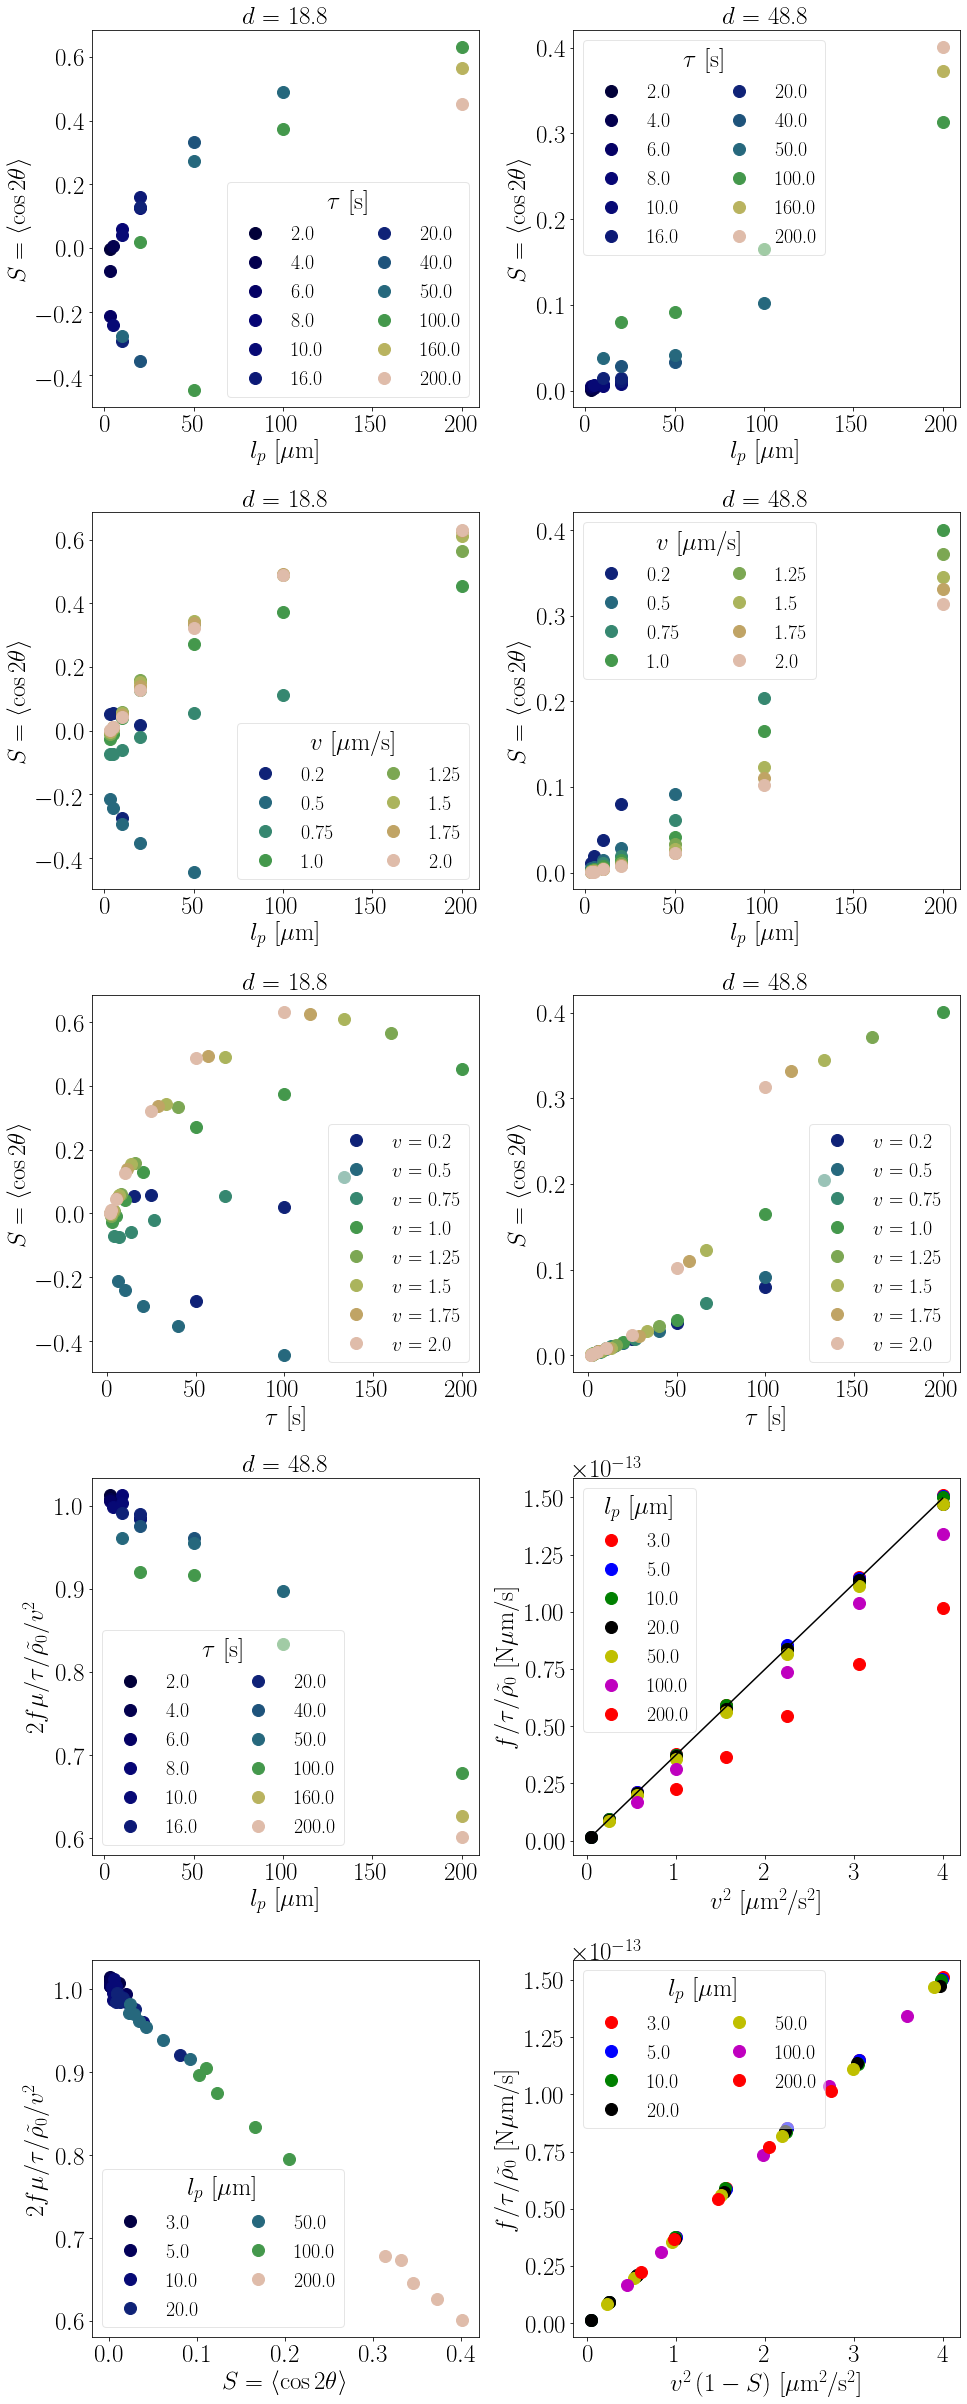

In [42]:
## Plot S vs. v [tau legend] at different distances. 
DistancesToPlot = [18.8, 48.8]
# DistancesToPlot = [18.8, 50]

alphaLegend = 0.5
# Tau_ToPlot_in_legend = np.sort(pd.unique(OrderParamDF['tau_s'].values))
Tau_ToPlot_in_legend = Tau_ToPlot_in_legend[Tau_ToPlot_in_legend % 2 == 0]
L_p_ToPlot_in_F_vs_v_squared = pd.unique(OrderParamDF['Persistence_length_um']) # [10, 20, 50, 75, 100, 150, 125, 200, 225]
# L_p_ToPlot_in_F_vs_v_squared = [20, 100, 200, 150, 225, 375]
# L_p_ToPlot_in_F_vs_v_squared = [3,5,10,20, 100, 200]
# L_p_ToPlot_in_F_vs_v_squared = [3,5,10,20]

ExportToFile = False
colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm'])
if 1:     # setting the grpah sizes
    plt.rcParams['font.size']=20
    plt.rcParams["font.family"] = "Times New Roman"
    SMALL_SIZE = 25
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 25
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    mpl.rc('image', cmap='gray')
    mpl.rc('text', usetex=True) # or plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
if 1: 
    from matplotlib import cm
    tau_list = Tau_ToPlot_in_legend
    fig, ax = plt.subplots(5,len(DistancesToPlot), figsize = (14,35))
    # first panel: S(l_p) legend tau
    for axesInd, distance in enumerate(DistancesToPlot):
        # tau_list = tau_list[np.mod(tau_list, 1) == 0]
        for tau in tau_list: 
            color = cm.gist_earth(int(254 * 0.9 * (tau/tau_list.max())))
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['tau_s'] == tau)]
            # label = '$\\tau$ = ' + str(tau)
            label = str(np.round(tau,1))
            ax[0,axesInd].plot(DFforPlot['Persistence_length_um'], DFforPlot['OrderParam'], 'o', 
                               markersize = 12, label = label, color = color)
        ax[0,axesInd].legend(fontsize = 20, framealpha = alphaLegend, ncol= 2, title = r'$\tau$ [s]')
        ax[0,axesInd].set_title(r'$d$ = ' + str(distance))
        ax[0,axesInd].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[0,axesInd].set_xlabel(r'$l_p$ [$\mu$m]')
    # Second panel: S(l_p) legend velocity
    for axesInd, distance in enumerate(DistancesToPlot):
        velocities = np.sort(pd.unique(OrderParamDF['velocity_umPs']))
        # velocities = velocities[np.mod(velocities, 1) == 0]
        for velocity in velocities:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['velocity_umPs'] == velocity)]
            label = r'$v$ = ' + str(velocity)
            label = str(velocity)
            color = cm.gist_earth(int(254 * 0.9 * (velocity/velocities.max())))
            ax[1,axesInd].plot(DFforPlot['Persistence_length_um'], DFforPlot['OrderParam'], 'o', 
                               markersize = 12, label = label, color = color)
        ax[1,axesInd].legend(fontsize = 20, framealpha = alphaLegend, ncol= 2, title = r'$v$ [$\mu$m/s]')
        ax[1,axesInd].set_title('$d$ = ' + str(distance))
        ax[1,axesInd].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[1,axesInd].set_xlabel(r'$l_p$ [$\mu$m]')
    # Panel 3: S(tau) legend velocity
    for axesInd, distance in enumerate(DistancesToPlot):
        velocities = np.sort(pd.unique(OrderParamDF['velocity_umPs']))
        # velocities = velocities[np.mod(velocities, 1) == 0]
        for velocity in velocities:        
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['velocity_umPs'] == velocity)]
            label = '$v$ = ' + str(velocity)
            color = cm.gist_earth(int(254 * 0.9 * (velocity/velocities.max())))
            ax[2,axesInd].plot(DFforPlot['tau_s'], DFforPlot['OrderParam'], 'o', 
                               markersize = 12, label = label, color = color)
        ax[2,axesInd].legend(fontsize = 20, framealpha = alphaLegend)
        ax[2,axesInd].set_title(r'$d$ = ' + str(distance))
        ax[2,axesInd].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[2,axesInd].set_xlabel(r'$\tau$ [s]')
    # Panel 4, left: Unitless force/force bulk theory
    for tau in tau_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['tau_s'] == tau)]
        label = str(np.round(tau,1))
        UnitlessForce = 2*DFforPlot['Force_Norm']/(DFforPlot['velocity_umPs']**2)/DFforPlot['drag_N_sPum']
        color = cm.gist_earth(int(254 * 0.9 * 
                                  (tau/tau_list.max()+0)))
        ax[3,0].plot(DFforPlot['Persistence_length_um'], UnitlessForce, 'o', 
                               markersize = 12, label = label, color = color)
    ax[3,0].legend(fontsize = 20, framealpha = alphaLegend, ncol = 2, title=r"$\tau$ [s]")
    ax[3,0].set_title(r'$d$ = ' + str(distance))
    ax[3,0].set_ylabel(r'$2f\mu/\tau/\tilde{\rho_0}/v^2 $')
    ax[3,0].set_xlabel(r'$l_p$ [$\mu$m]')
    # Panel 4, right: force theory:
    l_p_list = np.sort(L_p_ToPlot_in_F_vs_v_squared);
    for l in l_p_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
        label = str(l)
        color = next(colors)
        ax[3,1].plot(DFforPlot['velocity_umPs']**2, DFforPlot['Force_Norm'], 'o', 
                               markersize = 12, label = label, color = color)
    ax[3,1].set_ylabel(r'$f/\tau/\tilde{\rho_0}$ [N$\mu$m/s]')
    ax[3,1].set_xlabel(r'$v^2$ [$\mu$m$^2$/s$^2$]')
    ax[3,1].legend(fontsize = 20, framealpha = alphaLegend, title="$l_p$ [$\mu$m]")
    ax[3,1].plot(OrderParamDF['velocity_umPs']**2, 0.5*OrderParamDF['drag_N_sPum']*OrderParamDF['velocity_umPs']**2, 'k', label = 'Theory')
    # ax[3,1].set_xlim([-0.1,4.2])
    # ax[3,1].set_ylim([-0.5E-14,1.6E-13])
    # panel 5, left, f vs. S: 
    for l in l_p_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == 48.8) & (OrderParamDF['Persistence_length_um'] == l)]
        label = str(np.round(l,1))
        UnitlessForce = 2*DFforPlot['Force_Norm']/(DFforPlot['velocity_umPs']**2)/DFforPlot['drag_N_sPum']
        color = cm.gist_earth(int(254 * 0.9 * (l/l_p_list.max())))
        ax[4,0].plot(DFforPlot['OrderParam'], UnitlessForce, 'o', 
                               markersize = 12, label = label, color = color)
    ax[4,0].set_ylabel(r'$2f\mu/\tau/\tilde{\rho_0}/v^2$')
    ax[4,0].set_xlabel(r'$S = \left< \cos 2\theta \right>$')
    ax[4,0].legend(fontsize = 20, framealpha = alphaLegend, ncol =2, title=r"$l_p$ [$\mu$m]")
    # panel 5, right: renormalized f vs. v^2
    l_p_list = np.sort(L_p_ToPlot_in_F_vs_v_squared);
    colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm'])
    for l in l_p_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
        label = '$l_p$ = ' + str(l)
        label = str(l)
        # color = cm.hot(int(254 * 0.7 * (l/l_p_list.max())))
        color = next(colors)

        # color = cm.afmhot(int(254 * 0.7 * (l/l_p_list.max())))
        ax[4,1].plot((DFforPlot['velocity_umPs']**2)*(1-DFforPlot['OrderParam']), DFforPlot['Force_Norm'], 'o', 
                               markersize = 12, label = label, color = color)
    ax[4,1].set_ylabel(r'$f/\tau/\tilde{\rho_0}$ [N$\mu$m/s]')
    ax[4,1].set_xlabel(r'$v^2 \left(1-S\right)$ [$\mu$m$^2$/s$^2$]')
    ax[4,1].legend(fontsize = 20, framealpha = alphaLegend, ncol =2, title=r"$l_p$ [$\mu$m]")
    # ax[4,1].plot(OrderParamDF['velocity_umPs']**2, 0.5*OrderParamDF['drag_N_sPum']*OrderParamDF['velocity_umPs']**2, 'k', label = 'Theory')
    # general tidying
    fig.tight_layout()
    # fig.suptitle(subFolder.split('\\')[1]) 
    fig.subplots_adjust(top=0.95)
    if ExportToFile:
        exportFilename = CurrentFolder + r'\\' + r'OrderParamSummary_withThermalDiffusion.jpg'
        plt.savefig(exportFilename, dpi = 500)

In [41]:
OrderParamDF.loc[OrderParamDF['d_um'] == 48.8][['OrderParam', 'tau_s', 'velocity_umPs']].sort_values('tau_s')

,OrderParam,tau_s,velocity_umPs
4,0.000661,1.50,2.00
4,0.000755,1.71,1.75
4,0.001514,2.00,1.50
4,0.000901,2.40,1.25
4,0.001276,2.50,2.00
4,0.001532,2.86,1.75
4,0.002347,3.00,1.00
4,0.002348,3.33,1.50
4,0.002994,4.00,0.75
4,0.002957,4.00,1.25


### Other orientational stuff with displacements

In [218]:
BinSize_um = 0.25
# BinEdges = np.linspace(AllDistance.min(), AllDistance.max(), int(AllDistance.max()/BinSize_um))
BinEdges = np.linspace(y.min(), y.max(), int(y.max()/BinSize_um))

AvgXs = np.zeros(len(BinEdges)-1)
AvgYs = np.zeros(len(BinEdges)-1)
AvgVels = np.zeros(len(BinEdges)-1)
AvgThetas = np.zeros(len(BinEdges)-1)
AvgAbsYs, AvgAbsXs = np.zeros(len(BinEdges)-1), np.zeros(len(BinEdges)-1)
p_angles = np.mod(p, 2*np.pi)*180/np.pi
p_angles = - p_angles + 180
for ind in range(len(BinEdges)-1):
    start_um = BinEdges[ind]
    range_um = np.diff(BinEdges).mean()
    AvgYs[ind] = fps* dy[(y>=start_um) & (y<start_um+range_um)].mean()
    AvgThetas[ind] = p_angles[(y>=start_um) & (y<start_um+range_um)].mean()
    

    AvgVels[ind] = fps* (np.sqrt(dy[(y>=start_um) & (y<start_um+range_um)]**2 + 
                          dx[(y>=start_um) & (y<start_um+range_um)]**2)).mean()
    
    AvgVels[ind] = fps* np.sqrt((dy[(y>=start_um) & (y<start_um+range_um)]**2 + 
                          dx[(y>=start_um) & (y<start_um+range_um)]**2).mean())
    
    AvgXs[ind] = fps* dx[(y>=start_um) & (y<start_um+range_um)].mean()
    
    AvgAbsYs[ind] = fps* np.abs(dy[(y>=start_um) & (y<start_um+range_um)]).mean()
    AvgAbsXs[ind] = fps* np.abs(dx[(y>=start_um) & (y<start_um+range_um)]).mean()
    
# AvgAbsYs = AvgVels * np.abs(np.sin(AvgThetas)).mean()
# AvgAbsXs = AvgVels * np.abs(np.cos(AvgThetas)).mean()

C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of e

(0, 100)

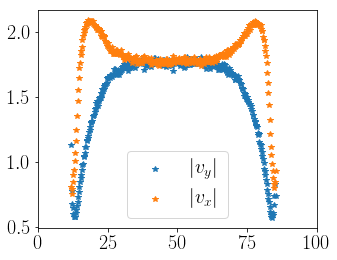

In [28]:
plt.figure(figsize=[5, 4])
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgAbsYs, '*')
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgAbsXs, '*')
plt.legend(['$|v_y|$','$|v_x|$'])
plt.xlim([0, 100])

(-0.1, 0.1)

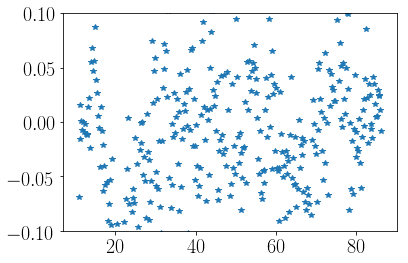

In [210]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgXs, '*')
plt.ylim([-0.1,0.1])

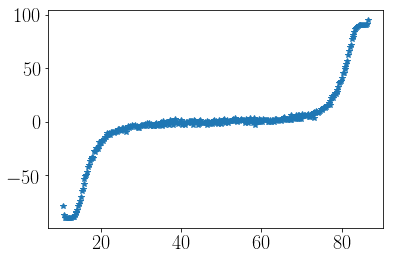

In [211]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgThetas, '*')
# plt.ylim([-0.1,0.1])

(0, 97)

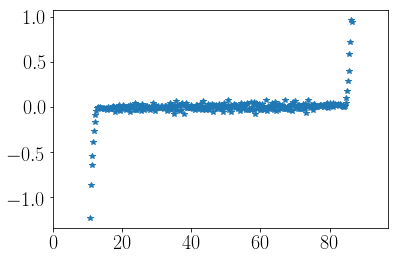

In [212]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgYs, '*')
plt.xlim([0,97])
# plt.ylim([-0.1, 0.1])

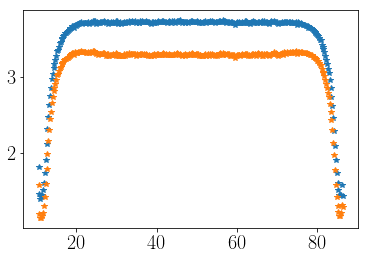

In [214]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgVels, '*')
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, np.sqrt(AvgAbsYs**2 + AvgAbsXs**2), '*')

# plt.ylim([-0.1,0.1])

# see Movie

In [79]:
filelistPDF

['C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls\\Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dragFactorToPsv_1p82_PDfunc.csv',
 'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls\\Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p1_NumPrtcls_10_dragFactorToPsv_1p82_PDfunc.csv']

In [80]:
movieName='Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dragFactorToPsv_1p82_coords.csv'
subFolder

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls')

In [81]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls'

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.08it/s]


min x: 100 min y: 14.4532259155639
max x: 393.5110900637284 max y: 84.86273049023447


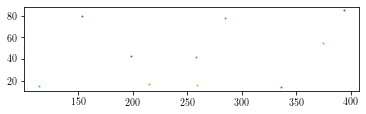

In [83]:
if 1:
    filename = str(subFolder/movieName)
    coords=np.genfromtxt(filename, delimiter=',')
    # Checking trajectories, last 50 steps
    fig, ax = plt.subplots()
    ParticlesToPlot=range(NumberOfParticles);
    maxy,maxx=0,100
    miny,minx=100,100
    for particleNum in tqdm(ParticlesToPlot):
        x=coords[-1:,3*particleNum+1]
        y=coords[-1:,3*particleNum+2]
        if y.max()>maxy:
            maxy=y.max() ;
        if y.min()<miny:
            miny=y.min() ;
        if x.max()>maxx:
            maxx=x.max() ;
        if x.min()<minx:
            minx=x.min() ;
        ax.plot(x,y,'8',markersize=1)
    # ax1.axis('equal')
    # ax1.set_xlim([0,BoxX])
    # ax1.set_ylim([0,BoxY])
    ax.set_aspect('equal')
    print('min x:', str(minx), 'min y:', str(miny))
    print('max x:', str(maxx), 'max y:', str(maxy))

In [89]:
DirName=subFolder/movieName[:-29]
DirName.mkdir(exist_ok=True)
DirName

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr')

In [90]:
len(coords)

10000

In [91]:
BoxX_um=400
ChannelLength_um=100
FrameIntervalForMovie=1; 
img=np.zeros([ChannelLength_um,BoxX_um])
MovieCoords=coords[::FrameIntervalForMovie,:]

In [92]:
def MakeFrameIndexForAnimation(FrameNum,MaximalFrameNum):
    IndexRequiredLength=len(str(MaximalFrameNum));
    LengthOfCurrentString=len(str(FrameNum))
    NumberOfZerosToAdd=IndexRequiredLength-LengthOfCurrentString;
    NewIndexForCurrentFrame='0'*NumberOfZerosToAdd+str(FrameNum)
    return NewIndexForCurrentFrame 
def format_func(value, tick_number):
    return str(int(value))

In [94]:
DirName

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr')

 55%|█████████████████████████████████████████▌                                 | 5544/10000 [2:22:00<12:11,  6.09it/s]

KeyboardInterrupt: 

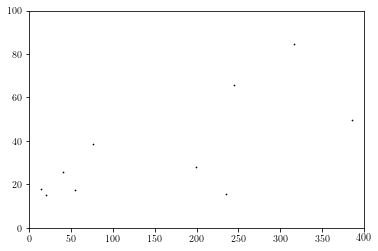

In [95]:
for i in tqdm(range(len(MovieCoords))):  # this list is using the cropped enumeration, starting at 0 for the cropped. 
    plt.ioff()
    fig, ax = plt.subplots()
    NewIndexForCurrentFrame=MakeFrameIndexForAnimation(i,len(MovieCoords)) # just an index to save the file on HD
    ax.scatter(MovieCoords[i,1::3], MovieCoords[i,2::3], marker ='.', s=2, color='k')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    pathname= DirName/('_'+NewIndexForCurrentFrame+'.png')
    ax.set_xlim([0,BoxX_um])
    ax.set_ylim([0,ChannelLength_um])
    fig.savefig(str(pathname), dpi=200)
    # fig.clf()
    plt.close(fig)

In [97]:
DirName

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr')

[WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00000.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00001.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00002.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00003.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00004.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00005.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00006.png'),
 WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_d

In [108]:
ImagIOfilename

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr/_00000.png')

In [112]:
DirNameForImageio

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr')

In [109]:
# To create a movie from the jpeg's
fps=10; 
temp=DirName
DirName=temp
DirNameForImageio=temp
filenamesForImageio = list(DirName.glob('*.png'))
import imageio
# DirNameForImageio='C:/Users/M/Dropbox/MicroOsmotic/Python/'+DirName
MovieFileNameImageIO=(movieName[:-4]+'.mp4')
DirNameForImageio=DirName
with imageio.get_writer(str(DirNameForImageio/MovieFileNameImageIO), mode='I', fps=fps) as writer:
    for ImagIOfilename in tqdm(filenamesForImageio):
        image = imageio.imread(str(ImagIOfilename))
        writer.append_data(image)
writer.close()


  7%|█████▏                                                                         | 362/5544 [00:08<01:44, 49.70it/s]


 13%|██████████▍                                                                    | 729/5544 [00:16<01:27, 54.98it/s]


 20%|███████████████▉                                                              | 1129/5544 [00:24<01:24, 52.31it/s]


 28%|█████████████████████▍                                                        | 1527/5544 [00:32<01:17, 51.64it/s]


 35%|███████████████████████████▏                                                  | 1934/5544 [00:39<01:06, 54.34it/s]


 42%|████████████████████████████████▌                                             | 2315/5544 [00:47<01:11, 45.44it/s]


 49%|██████████████████████████████████████▏                                       | 2712/5544 [00:55<00:50, 56.23it/s]


 56%|███████████████████████████████████████████▋                                  | 3108/5544 [01:02<01:00, 40.51it/s]


 62%|████████████████████████████████████████████████▌                             | 3451/5544 [01:10<00:49, 42.31it/s]


 70%|██████████████████████████████████████████████████████▎                       | 3856/5544 [01:18<00:34, 48.28it/s]


 76%|███████████████████████████████████████████████████████████▎                  | 4215/5544 [01:25<00:24, 53.82it/s]


 83%|████████████████████████████████████████████████████████████████▋             | 4597/5544 [01:33<00:17, 54.09it/s]


 90%|██████████████████████████████████████████████████████████████████████▍       | 5005/5544 [01:41<00:10, 51.12it/s]


 98%|████████████████████████████████████████████████████████████████████████████  | 5407/5544 [01:49<00:02, 55.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 5544/5544 [01:51<00:00, 49.70it/s]


In [117]:
MovieFileNameImageIO

'/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dragFactorToPsv_1p82_coords.mp4'

In [116]:
DirNameForImageio/ MovieFileNameImageIO

WindowsPath('/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dragFactorToPsv_1p82_coords.mp4')

In [113]:
DirNameForImageio

WindowsPath('20190926_HMDS_AF_tau_SDS_Relay/InteractingPartcls/Sim_V_8_vel_1_Dt_0p1_C_1_Dr_0p02_NumPrtcls_10_dr')

# Calculating orientation analytically

In [162]:
def CalcProbabilityForThetaOrientation(velocity, tau, regionSize_um, theta_rad):
    if type(a) != np.ndarray:
        theta_rad = np.array([theta_rad])
    TimeInRegion_s = np.zeros(len(theta_rad))
    criticalTheta = np.arcsin(regionSize_um/(tau*velocity))
    
    TimeInRegion_s[theta_rad < criticalTheta] = tau 
    TimeInRegion_s[theta_rad > criticalTheta] = regionSize_um/velocity/np.sin(theta_rad[theta_rad > criticalTheta]) 
    
    Probability = TimeInRegion_s / np.sum(TimeInRegion_s * np.diff(theta_rad).mean())
   
    return Probability        

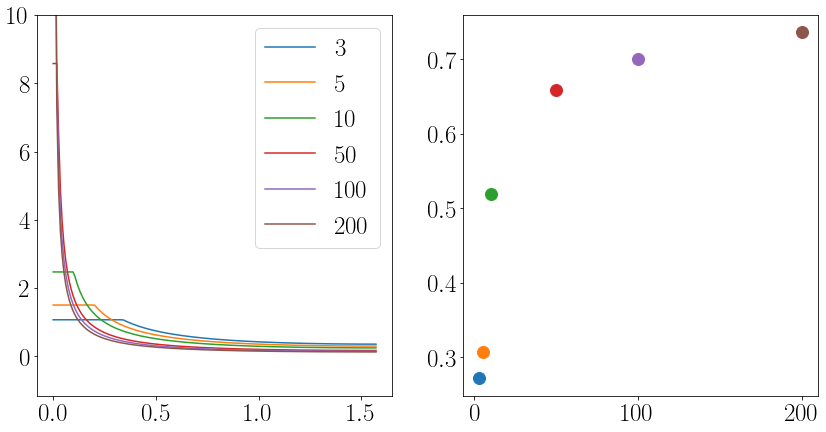

In [304]:
tau_s = [3, 5, 10, 50, 100, 200]
velocity = 2 
regionSize_um = 2
theta_rad = np.linspace(0, np.pi/2, 180)
fig, ax = plt.subplots(1,2, figsize = (14,7))
for tau in tau_s:
    ProbabilityForThetaOrientation = CalcProbabilityForThetaOrientation(velocity, tau, regionSize_um, theta_rad)
    ax[0].plot(theta_rad , ProbabilityForThetaOrientation, label = str(tau))
    S = (2*np.cos(ProbabilityForThetaOrientation)**2 - 1).mean() # order parameter
    ax[1].plot(tau, S, 'o', markersize = 12)
ax[0].legend();
ax[0].set_ylim(top = 10);

0.1287725152536643

In [145]:
a = np.array([5,6,7,4])


In [141]:
a = np.array([5])
for b in a:
    print(b)

5


In [143]:
a = np.array([5,6,7,4])
a = np.array([a])
for b in a:
    print(b)

[5 6 7 4]
